In [ ]:
import pandas as pd #pandas: For data manipulation and loading the dataset.
from sklearn.impute import SimpleImputer #SimpleImputer: Used for imputing missing values in the data (filling missing values).
from sklearn.preprocessing import StandardScaler, OneHotEncoder #StandardScaler: Standardizes numerical features by scaling them to have zero mean and unit variance.
                                                                #OneHotEncoder: Encodes categorical variables into numerical data by creating binary columns for each category.
from sklearn.compose import ColumnTransformer #ColumnTransformer: Allows applying different preprocessing pipelines to numerical and categorical features in a single step
from sklearn.pipeline import Pipeline #Pipeline: Chains preprocessing steps and model training into a single step.
from sklearn.model_selection import train_test_split #train_test_split: Splits the data into training and testing sets.
from sklearn.ensemble import RandomForestClassifier #RandomForestClassifier: A machine learning model used for classification tasks.
from sklearn.metrics import accuracy_score, classification_report #accuracy_score and classification_report: Metrics for model evaluation.
from sklearn.utils import resample #accuracy_score and classification_report: Metrics for model evaluation.

# Load the dataset
df = pd.read_csv('titanic_data.csv', keep_default_na=False)

# Feature engineering: Extract title from the "Name" column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# Separate features and target
attributes = df.drop('Survived', axis=1)
target = df['Survived']

# Identify numerical and categorical columns
numeric_features = attributes.select_dtypes(include=['int64', 'float64']).columns
categorical_features = attributes.select_dtypes(include=['object']).columns


# Custom function for handling outliers
def handle_outliers(df, column, lower_quantile=0.05, upper_quantile=0.95):
    """
    Clips values in a column to within the specified quantile range.
    """
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)


    # Apply outlier handling to numeric features
for col in numeric_features:
    handle_outliers(df, col)



# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # most frequently occurring value (mode)
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #Converts categorical features into binary columns using one-hot encoding
    #handle_unknown='ignore': Ensures that any new categories during prediction won't cause an error
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Define the Random Forest model with balanced class weights
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Upsampling
#takes random sample from minority 
df_majority = df[df['Survived'] == 0]
df_minority = df[df['Survived'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Use upsampled data for training/testing
attributes_upsampled = df_upsampled.drop('Survived', axis=1)
target_upsampled = df_upsampled['Survived']

# Split upsampled data into training and testing sets
xtrain, xtest, ytrain, ytest = train_test_split(
    attributes_upsampled, target_upsampled, test_size=0.3, random_state=42, stratify=target_upsampled
)

# Adjusts the model's internal parameters (e.g., decision trees in a Random Forest)
# to minimize the error or maximize predictive performance based on the training data

# Fit the pipeline
pipeline.fit(xtrain, ytrain)

# Make predictions
ypred = pipeline.predict(xtest)



In [55]:
print(df_upsampled.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
dtype: int64


In [56]:
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision:", precision_score(ytest, ypred))
print("Recall:", recall_score(ytest, ypred))
print("F1 Score:", f1_score(ytest, ypred))


Precision: 0.8524590163934426
Recall: 0.9454545454545454
F1 Score: 0.896551724137931


C:\Users\yumenna ezzat\AppData\Local\Temp\ipykernel_15164\2115228449.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, palette="viridis")
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


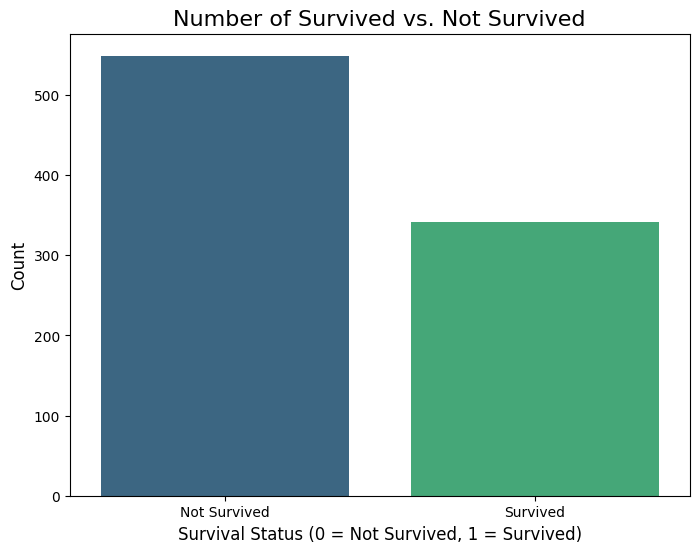

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the counts of Survived and Not Survived
plt.figure(figsize=(8, 6))
sns.countplot(x=target, palette="viridis")
plt.title("Number of Survived vs. Not Survived", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

C:\Users\yumenna ezzat\AppData\Local\Temp\ipykernel_15164\678506401.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_upsampled['Survived'], palette="viridis")
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_

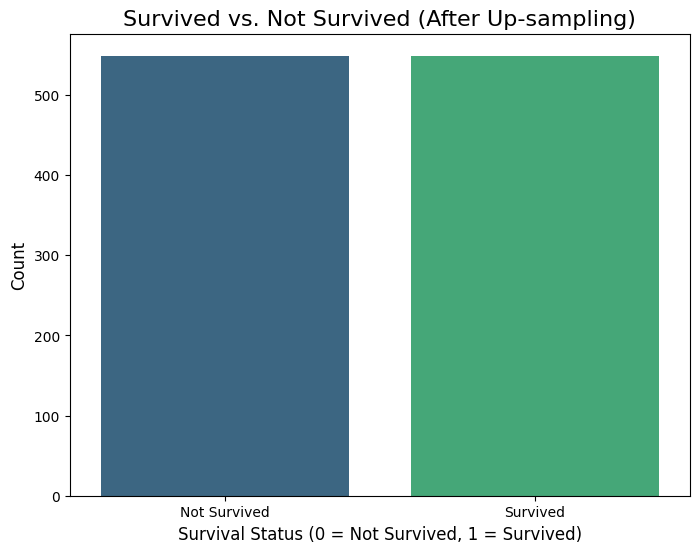

In [ ]:
# Plot the upsampled class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x=df_upsampled['Survived'], palette="viridis")
plt.title("Survived vs. Not Survived (After Up-sampling)", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

In [50]:
# Evaluate the model
accuracy = pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")


Accuracy on test set: 0.89


In [51]:
#Actual VS Predicted 
y_pred = pipeline.predict(xtest)

results_df = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred
})

print("Actual vs Predicted Values:")
print(results_df)

Actual vs Predicted Values:
     Actual  Predicted
380       1          1
141       1          1
283       1          1
143       0          0
480       0          0
..      ...        ...
148       0          0
600       1          1
836       0          0
180       0          0
192       1          1

[330 rows x 2 columns]


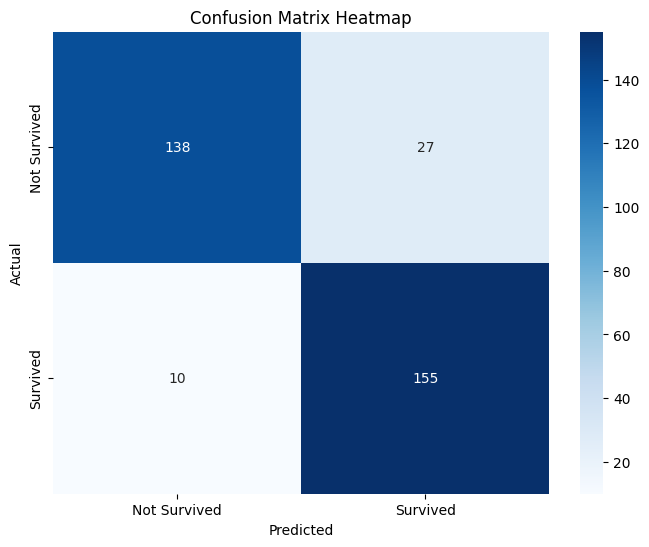

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(ytest, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()


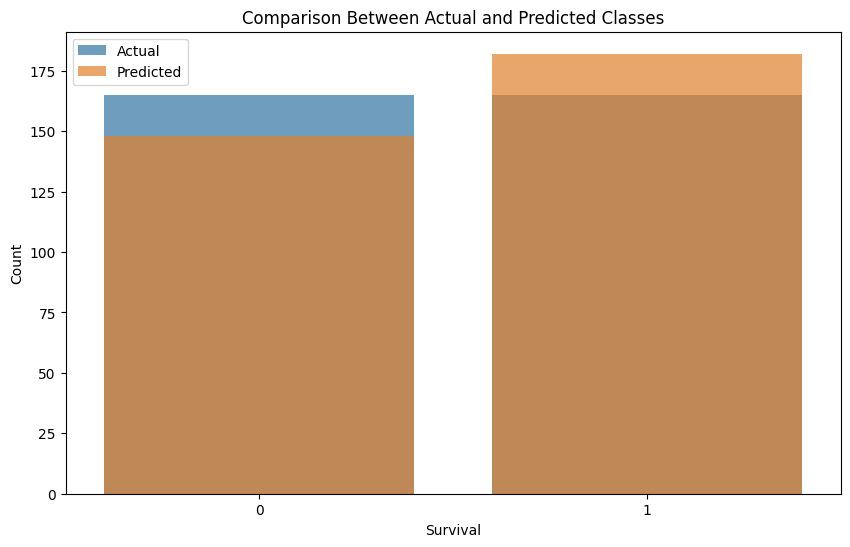

In [28]:
# Create a DataFrame for visualization
results_df = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})

plt.figure(figsize=(10, 6))
sns.countplot(x='Actual', data=results_df, alpha=0.7, label="Actual")
sns.countplot(x='Predicted', data=results_df, alpha=0.7, label="Predicted")
plt.xlabel('Survival')
plt.ylabel('Count')
plt.title('Comparison Between Actual and Predicted Classes')
plt.legend()
plt.show()



In [44]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(ytest, pipeline.predict(xtest))
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.88       165
           1       0.85      0.95      0.90       165

    accuracy                           0.89       330
   macro avg       0.90      0.89      0.89       330
weighted avg       0.90      0.89      0.89       330



In [53]:

# Prediction for multiple unseen samples entered manually
def predict_unseen_sample():
   
    try:
        # How many unseen samples you want
        num_samples = int(input("\nHow many unseen samples would you like to test with? "))

        for i in range(num_samples):
            print(f"\nInput data for sample {i + 1}:")
            # Input prompts for each unseen sample
            pclass = int(input("Pclass (1, 2, 3): "))
            name = input("Name (e.g., John): ")
            sex = input("Sex (male/female): ")
            age = float(input("Age (e.g., 28): "))
            sibsp = int(input("Siblings/Spouses aboard (e.g., 0, 1): "))
            parch = int(input("Parents/Children aboard (e.g., 0, 1): "))
            fare = float(input("Fare (e.g., 50): "))
            embarked = input("Embarked (S, C, Q): ")

            # Create a dictionary for the user-provided input
            manual_input = {
                "Pclass": pclass,
                "Name": name,
                "Sex": sex,
                "Age": age,
                "SibSp": sibsp,
                "Parch": parch,
                "Fare": fare,
                "Embarked": embarked,
                "PassengerId": 0,
                "Ticket": 0,
                "Cabin": 0
            }

            # Convert dictionary to DataFrame
            unseen_df = pd.DataFrame([manual_input])

            # Feature engineering - ensure the 'Title' feature is added to unseen data
            unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

            # Pass the preprocessed unseen sample into the pipeline
            prediction = pipeline.predict(unseen_df)

            # Output the prediction
            unseen_df['Survived_Prediction'] = prediction
            print("\nPrediction made successfully!")
            print(unseen_df[['Name', 'Survived_Prediction']])

    except Exception as e:
        print("\nError predicting unseen sample:", e)

In [54]:

predict_unseen_sample()


Input data for sample 1:

Prediction made successfully!
   Name  Survived_Prediction
0  john                    0


In [41]:
# Prediction for unseen sample
def predict_unseen_sample(file_path):
  
    # Load the unseen sample
    try:
        unseen_df = pd.read_csv(file_path)
        print("Sample loaded successfully!")

        # Feature engineering - ensure the 'Title' feature is added to unseen data
        unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        # Drop rows with missing values in critical features if necessary
        unseen_df.dropna(subset=['Age', 'Fare', 'Sex'], inplace=True)

        # Pass the preprocessed unseen sample into the pipeline
        prediction = pipeline.predict(unseen_df)

        # Output the prediction
        unseen_df['Survived_Prediction'] = prediction
        print("Prediction made successfully!")
        print(unseen_df[['Name', 'Survived_Prediction']])
    except Exception as e:
        print("Error loading or predicting unseen sample:", e)




In [ ]:
# Example usage - pass the path to your unseen sample here
unseen_file_path = 'unseen_sample.csv'  # Replace with actual file path
predict_unseen_sample(unseen_file_path)